# Load Dataset and Libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy.stats import skew
from scipy.stats import uniform

from xgboost import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import make_scorer 

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, plot_confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
# ignore Deprecation Warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [2]:
data = pd.read_csv('data/healthcare-dataset-stroke-data.csv')

data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


The dataset includes data of 5110 patients, 10 predict variables and 1 target variable

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
df = data.copy()

Next, we check the number of NA value in each columns. Then, we could see that BMI column has many NA values (3.9%). We will process these NA values in the Data Processing part.

In [5]:
df.isna().sum()/len(df)

id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  0.039335
smoking_status       0.000000
stroke               0.000000
dtype: float64

# Data Overview
In this section, we will go over every feature in the dataset and review their distributions, correlations with the predict value (stroke)

In the dataset, only 5% of the patients are identified with stroke, thus we need to apply stratify sampling the train and test dataset

In [6]:
df['stroke'].value_counts()/len(df)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

Text(0, 0.5, 'Number of patients')

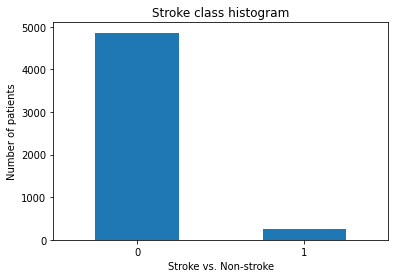

In [7]:
stroke = df['stroke'].value_counts()
stroke.plot(kind='bar')
plt.xticks(rotation='0')
plt.title("Stroke class histogram")
plt.xlabel("Stroke vs. Non-stroke")
plt.ylabel("Number of patients")

(array([ 411., 1964., 1809.,  575.,  105.,   37.,    4.,    2.,    0.,
           2.]),
 array([10.3 , 19.03, 27.76, 36.49, 45.22, 53.95, 62.68, 71.41, 80.14,
        88.87, 97.6 ]),
 <BarContainer object of 10 artists>)

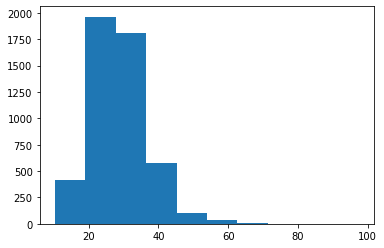

In [8]:
# Next, inspect the BMI distribution
plt.hist(df['bmi'])

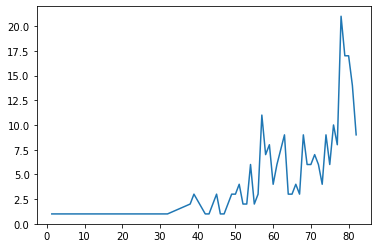

In [9]:
stroke = df[df['stroke'] == 1]
# plt.plot(stroke['stroke'], stroke['age'])
stroke_age = stroke.groupby('age', as_index=False).size()
plt.plot(stroke_age['age'], stroke_age['size'])

90% of the stroke patients is over 40yo

(array([1., 1., 0., 1., 2., 7., 8., 7., 8., 9.]),
 array([ 1.32 ,  9.388, 17.456, 25.524, 33.592, 41.66 , 49.728, 57.796,
        65.864, 73.932, 82.   ]),
 <BarContainer object of 10 artists>)

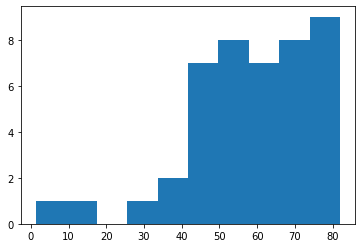

In [10]:
plt.hist(stroke_age['age'])

People with hypertension has 4 times higher possibility to get stroke (15% vs. 4% of hypertension vs. non-hypertension)

In [11]:
pd.crosstab(df['stroke'], df['hypertension'])

hypertension,0,1
stroke,,
0,4429,432
1,183,66


There is no significant correlation between residence type and stroke tendency

In [12]:
pd.crosstab(df['stroke'], df['Residence_type'])

Residence_type,Rural,Urban
stroke,,
0,2400,2461
1,114,135


Married people is 8 times more likely to have stroke than single people. However, this could be a bias because married people is more likely to be older and is more likely to have stroke

In [13]:
pd.crosstab(df['stroke'], df['ever_married'])/len(df)

ever_married,No,Yes
stroke,,
0,0.338160,0.613112
1,0.005675,0.043053


In [14]:
age_marry = pd.pivot_table(data, index='age', columns='ever_married', values='stroke' ,aggfunc=np.size, fill_value=0)
age_marry.reset_index(inplace=True)

In [15]:
age_marry.columns

Index(['age', 'No', 'Yes'], dtype='object', name='ever_married')

The below charts confirm our hypothesis: the correlation between Marital status and Stroke is spurious, because the true causal relationship is Age.

(array([40., 28.,  5.,  3.,  5.,  8.,  3.,  2.,  7.,  3.]),
 array([ 0. ,  6.5, 13. , 19.5, 26. , 32.5, 39. , 45.5, 52. , 58.5, 65. ]),
 <BarContainer object of 10 artists>)

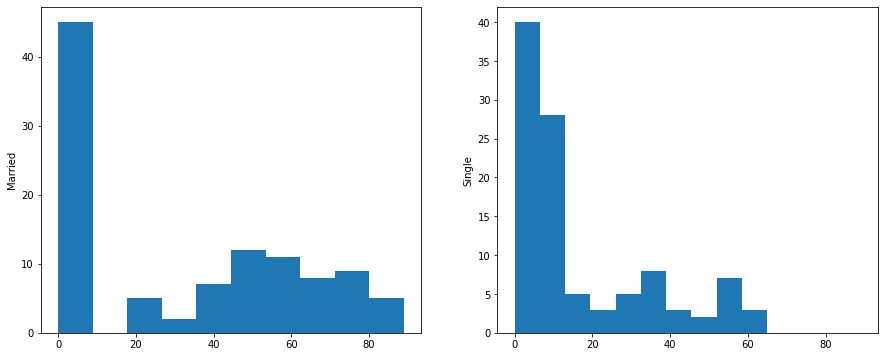

In [16]:
fig, axes = plt.subplots(figsize=(15,6), nrows=1, ncols=2, sharex=True)

ax = axes[0]
ax.set_ylabel("Married")
ax.hist(age_marry['Yes'], label='Married people age')

ax = axes[1]
ax.set_ylabel("Single")
ax.hist(age_marry['No'], label='Single people age')

There is not signifcant difference in likability to have stroke between Male and Female 

In [17]:
pd.crosstab(df['stroke'], df['gender'])/len(df)

gender,Female,Male,Other
stroke,,,
0,0.558317,0.392759,0.000196
1,0.027593,0.021135,0.000000


In order to check the correlation of each feature with one another, we create the correlation map

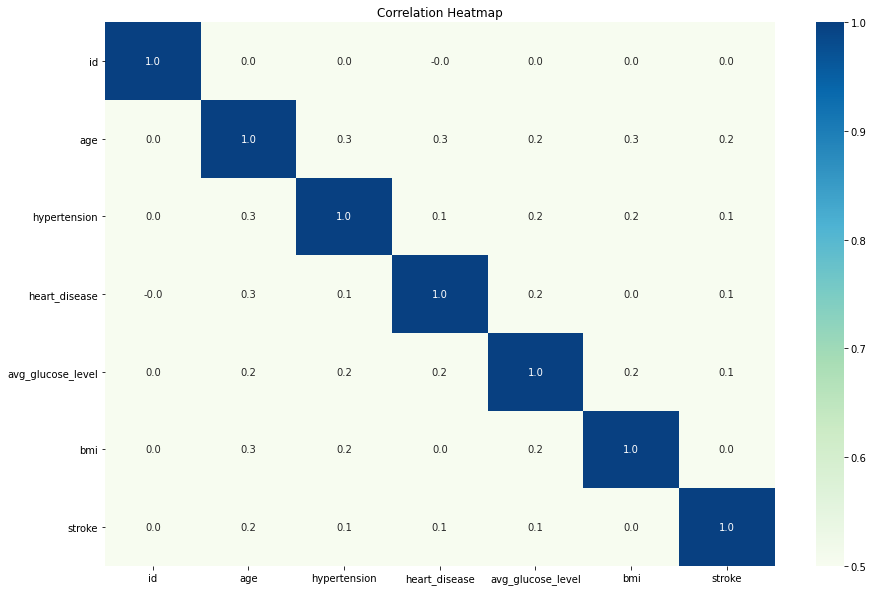

In [18]:
# Create correlation matrix from train data excluding `SalePrice`
corr_mat = df.corr()

# Select correlations greater than 0.5
high_corr_mat = corr_mat[abs(corr_mat) >= 0.4]

# Plot correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat,
            annot=True,
            fmt='.1f',
            cmap='GnBu',
            vmin=0.5,
            vmax=1)
title = plt.title('Correlation Heatmap')

# Data Processing

We create dummy valus for categorical features

In [19]:
df = pd.get_dummies(data, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])


As mentioned earlier, 3.9% of bmi is NA values. We replace these NA values with mean bmi value

In [20]:
mean_bmi = df['bmi'].mean()
df['bmi'].fillna(value=mean_bmi, inplace=True)
df['bmi'].isna().sum()

0

We review the columns, all NA values are gone

In [21]:
df[df['bmi'] == 'NaN'].value_counts()

Series([], dtype: int64)

In [22]:
df.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.600000,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0
1,51676,61.0,0,0,202.21,28.893237,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0
2,31112,80.0,0,1,105.92,32.500000,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,60182,49.0,0,0,171.23,34.400000,1,1,0,0,...,0,1,0,0,0,1,0,0,0,1
4,1665,79.0,1,0,174.12,24.000000,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0


To improve model accuracy, I standardize features with large range using standard scaler

In [23]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
df['age_scaled'] = std_scaler.fit_transform(df['age'].values.reshape(-1,1))
df['avg_glucose_level_scaled'] = std_scaler.fit_transform(df['avg_glucose_level'].values.reshape(-1,1))
df['bmi_scaled'] = std_scaler.fit_transform(df['bmi'].values.reshape(-1,1))
# df['avg_glucose_level_scaled'] = std_scaler.fit_transform(df['avg_glucose_level'].values.reshape(-1,1))
# df['avg_glucose_level_scaled'] = std_scaler.fit_transform(df['avg_glucose_level'].values.reshape(-1,1))

We review "age_scaled", the column we have applied StandardScaler

In [24]:
df['age_scaled']

0       1.051434
1       0.786070
2       1.626390
3       0.255342
4       1.582163
          ...   
5105    1.626390
5106    1.670617
5107   -0.363842
5108    0.343796
5109    0.034205
Name: age_scaled, Length: 5110, dtype: float64

Then, we remove the original columns from dataset to start training for models

In [25]:
df.drop(['id','age','avg_glucose_level','bmi'],axis=1, inplace=True)


# Prepare data for model

In [26]:
# Create X and y for models
X = df.drop('stroke', axis=1)
y = df['stroke']

In [27]:
# Using train_test_split to split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

We could see that the stroke class (5%) is overwhelmed by non-stroke class (95%). Models could not learn well if the dataset is significantly imbalance. The strategy to fix this imbalance is to use SMOTE (oversampling technique) to increase number of stroke equal to non-stroke in training data so models could learn better. Then we will use the model to predict the original test data.

In [28]:
y_test.value_counts()/len(y_test)

0    0.951076
1    0.048924
Name: stroke, dtype: float64

In [29]:
y_train.value_counts()/len(y_train)

0    0.951356
1    0.048644
Name: stroke, dtype: float64

In [30]:
import imblearn
from imblearn.over_sampling import SMOTE
print(imblearn.__version__)


0.8.1


In [31]:
oversample = SMOTE()
X_train_resh, y_train_resh = oversample.fit_resample(X_train, y_train.ravel())

In [32]:
# Now train data is more balanced between 0 and 1
np.unique(y_train_resh, return_counts=True)

(array([0, 1]), array([3403, 3403]))

# Modelling

We will use 3 models: Random Forest, Logistics Regression and Support Vector Machine. Because these 3 models are normally the best performers in classification exercises.

In [33]:
rf = RandomForestClassifier(random_state=52)
svm = SVC(random_state=52)
logreg = LogisticRegression(random_state=52, max_iter = 10000)

In [34]:
# Create cross validation score 
rf_cv = cross_val_score(rf, X_train_resh, y_train_resh, cv=10, scoring='f1')
svm_cv = cross_val_score(svm, X_train_resh, y_train_resh, cv=10, scoring='f1')


In [35]:
logreg_cv = cross_val_score(logreg, X_train_resh, y_train_resh, cv=10, scoring='f1')

In [36]:
print('Mean f1 scores:')
print('Random Forest mean :',cross_val_score(rf,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())
print('SVM mean :',cross_val_score(svm,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())
print('Logistic Regression mean :',cross_val_score(logreg,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())

Mean f1 scores:
Random Forest mean : 0.9606897075717606
SVM mean : 0.918167406695129
Logistic Regression mean : 0.8675209416508363


In [37]:
rf.fit(X_train_resh, y_train_resh)
svm.fit(X_train_resh, y_train_resh)
logreg.fit(X_train_resh, y_train_resh)

LogisticRegression(max_iter=10000, random_state=52)

In [38]:
rf_pred = rf.predict(X_test)
svm_pred = svm.predict(X_test)
logreg_pred = logreg.predict(X_test)

In [39]:
# create confusion matrix
rf_cm = confusion_matrix(y_test,rf_pred)
svm_cm = confusion_matrix(y_test,svm_pred)
logreg_cm = confusion_matrix(y_test,logreg_pred)

In [40]:
# calculate f1 score
rf_f1 = f1_score(y_test, rf_pred)
svm_f1 = f1_score(y_test, svm_pred)
logreg_f1 = f1_score(y_test, logreg_pred)

Logistic Regression has the best F1 score among all models

In [41]:
print('Mean f1 scores:')

print('RF mean :',rf_f1)
print('SVM mean :',svm_f1)
print('LR mean :',logreg_f1)

Mean f1 scores:
RF mean : 0.0945945945945946
SVM mean : 0.13197969543147206
LR mean : 0.26153846153846155


We create classification report and accuracy score for each model

In [42]:
# RF report
print(classification_report(y_test,rf_pred))

print('Accuracy Score: ',accuracy_score(y_test,rf_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1458
           1       0.10      0.09      0.09        75

    accuracy                           0.91      1533
   macro avg       0.52      0.52      0.52      1533
weighted avg       0.91      0.91      0.91      1533

Accuracy Score:  0.9125896934116112


In [43]:
# SVM report
print(classification_report(y_test,svm_pred))

print('Accuracy Score: ',accuracy_score(y_test,svm_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1458
           1       0.11      0.17      0.13        75

    accuracy                           0.89      1533
   macro avg       0.53      0.55      0.54      1533
weighted avg       0.91      0.89      0.90      1533

Accuracy Score:  0.8884540117416829


In [44]:
# Logreg report
print(classification_report(y_test,logreg_pred))

print('Accuracy Score: ',accuracy_score(y_test,logreg_pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      1458
           1       0.18      0.45      0.26        75

    accuracy                           0.87      1533
   macro avg       0.58      0.67      0.60      1533
weighted avg       0.93      0.87      0.90      1533

Accuracy Score:  0.8747553816046967


Although Logistics Regression has lowest accuracy score, this model has much better recall score than Random Forest and SVM. However, all of the models perform poorly in indentifying the correct stroke patients. We will need to tune our models with parameters and Gridsearch.

## Perform gridsearch to improve recall

### Gridsearch on Random Forest

In [45]:
n_estimators = [64, 100, 128, 200]
max_features = [2,3,5,7]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'boostrap': bootstrap}

In [46]:
grid = GridSearchCV(rf, param_grid=param_grid)
# rfc = RandomForestClassifier()

In [47]:
rf = RandomForestClassifier(max_features=4, n_estimators=100, criterion='gini', bootstrap=True)
rf.fit(X_train_resh, y_train_resh)
rfc_pred_tuned = rf.predict(X_test)

RF has very high accuracy score, however recall is still very low (11%)

In [48]:
# RF report
print(classification_report(y_test,rfc_pred_tuned))

print('Accuracy Score: ',accuracy_score(y_test,rfc_pred_tuned))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1458
           1       0.11      0.12      0.12        75

    accuracy                           0.91      1533
   macro avg       0.53      0.54      0.54      1533
weighted avg       0.91      0.91      0.91      1533

Accuracy Score:  0.9112850619699935


### Gridsearch on Logistic Regression

In [49]:
penalty = ['l1', 'l2']
C = [0.001, 0.01, 0.1, 1, 10, 100]

log_param_grid = {'penalty': penalty, 'C': C}

logreg = LogisticRegression(max_iter=10000)
grid = GridSearchCV(logreg, param_grid=log_param_grid)

In [50]:
# grid.fit(X_train_resh,y_train_resh)

In [51]:
logreg = LogisticRegression(C=0.001, penalty='l2', random_state=55, max_iter=10000)
logreg.fit(X_train_resh, y_train_resh)

LogisticRegression(C=0.001, max_iter=10000, random_state=55)

In [52]:
logreg_pred_tuned = logreg.predict(X_test)

In contrast with RF, Logreg shows siginificant improvement in recall score (84%). However, accuracy score is 72% meaning there are a lot of non-stroke people are labeled stroke

In [53]:
# RF report
print(classification_report(y_test,logreg_pred_tuned))

print('Accuracy Score: ',accuracy_score(y_test,logreg_pred_tuned))

              precision    recall  f1-score   support

           0       0.99      0.73      0.84      1458
           1       0.14      0.84      0.24        75

    accuracy                           0.73      1533
   macro avg       0.56      0.78      0.54      1533
weighted avg       0.95      0.73      0.81      1533

Accuracy Score:  0.7332028701891715


### Gridsearch on SVM

In [54]:
svm = SVC(C=0.1, gamma=0.01, kernel='rbf', random_state=59)

svm.fit(X_train_resh, y_train_resh)
svm_pred_tuned = svm.predict(X_test)

SVM performance is very similar to Logistic Regression. with only slightly lower accuracy (71%)

In [55]:
# RF report
print(classification_report(y_test,svm_pred_tuned))

print('Accuracy Score: ',accuracy_score(y_test,svm_pred_tuned))

              precision    recall  f1-score   support

           0       0.99      0.72      0.83      1458
           1       0.13      0.81      0.22        75

    accuracy                           0.73      1533
   macro avg       0.56      0.77      0.53      1533
weighted avg       0.94      0.73      0.80      1533

Accuracy Score:  0.7253750815394651


## Model comparisons

We compare the 3 models using classification report, ROC curve 

In [56]:
ns_probs = [0 for _ in range((len(y_test)))]

lr_probs = logreg.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

In [57]:
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

In [58]:
y_scores = logreg.predict_proba(X_train)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

Below we inspect the ROC curve of Logistic Regression and its performance

As mentioned earlier, LogReg has higher recall but low accuracy, meaning it predicts more people to have a stroke - which in itself would have negative effects.

/var/folders/60/gmbxqch57r53py2v67gwvz780000gn/T/ipykernel_20087/1697946694.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  ax[0].plot(thresholds, precisions[:-1], 'b--', label='Precision',color='#9bb7d4')


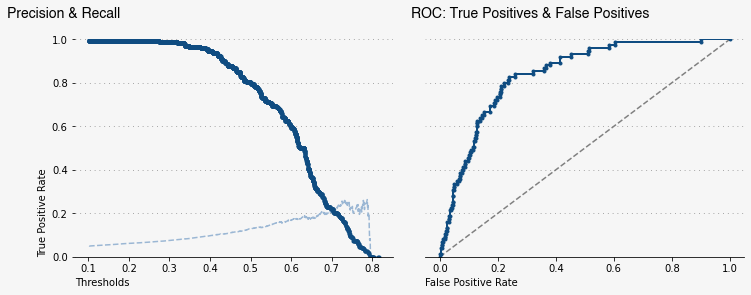

In [59]:
fig = plt.figure(figsize=(12,4))
gs = fig.add_gridspec(1,2,wspace=0.1, hspace=0)
ax = gs.subplots()

background_color = "#f6f6f6"
fig.patch.set_facecolor(background_color) # figure background color
ax[0].set_facecolor(background_color) 
ax[1].set_facecolor(background_color)

ax[0].grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax[1].grid(color='gray', linestyle=':', axis='y',  dashes=(1,5))



y_scores = logreg.predict_proba(X_train)[:,1]


precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

ax[0].plot(thresholds, precisions[:-1], 'b--', label='Precision',color='#9bb7d4')
ax[0].plot(thresholds, recalls[:-1], '.', linewidth=1,label='Recall',color='#0f4c81')
ax[0].set_ylabel('True Positive Rate',loc='bottom')
ax[0].set_xlabel('Thresholds',loc='left')
#plt.legend(loc='center left')
ax[0].set_ylim([0,1])


# plot the roc curve for the model
ax[1].plot(ns_fpr, ns_tpr, linestyle='--', label='Dummy Classifer',color='gray')
ax[1].plot(lr_fpr, lr_tpr, marker='.', linewidth=2,color='#0f4c81')
ax[1].set_xlabel('False Positive Rate',loc='left')
ax[1].set_ylabel('')
ax[1].set_ylim([0,1])

for s in ["top","right","left"]:
    ax[0].spines[s].set_visible(False)
    ax[1].spines[s].set_visible(False)
    
# ax[0].text(-0.1,2,'Model Selection: Considerations',fontsize=18,fontfamily='Helvetica',fontweight='bold')


ax[0].text(-0.1,1.1,'Precision & Recall',fontsize=14,fontfamily='Helvetica',fontweight='bold')
ax[1].text(-0.1,1.1,'ROC: True Positives & False Positives',fontsize=14,fontfamily='Helvetica',fontweight='bold')

ax[1].tick_params(axis='y', colors=background_color)

plt.show()

In [60]:
# create confusion matrix
rf_cm = confusion_matrix(y_test,rfc_pred_tuned)
svm_cm = confusion_matrix(y_test,svm_pred_tuned)
logreg_cm = confusion_matrix(y_test,logreg_pred_tuned)

In [61]:
# Make dataframes to plot

rf_df = pd.DataFrame(data=[f1_score(y_test,rfc_pred_tuned),accuracy_score(y_test, rfc_pred_tuned), recall_score(y_test, rfc_pred_tuned),
                   precision_score(y_test, rfc_pred_tuned), roc_auc_score(y_test, rfc_pred_tuned)], 
             columns=['Random Forest Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

svm_df = pd.DataFrame(data=[f1_score(y_test,svm_pred_tuned),accuracy_score(y_test, svm_pred_tuned), recall_score(y_test, svm_pred_tuned),
                   precision_score(y_test, svm_pred_tuned), roc_auc_score(y_test, svm_pred_tuned)], 
             columns=['Support Vector Machine (SVM) Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

lr_df = pd.DataFrame(data=[f1_score(y_test,logreg_pred_tuned),accuracy_score(y_test, logreg_pred_tuned), recall_score(y_test, logreg_pred_tuned),
                   precision_score(y_test, logreg_pred_tuned), roc_auc_score(y_test, logreg_pred_tuned)], 
             columns=['Tuned Logistic Regression Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

We summary the classification of all models in below table

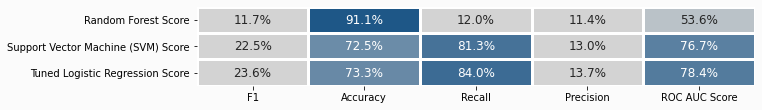

In [62]:
df_models = round(pd.concat([rf_df,svm_df,lr_df], axis=1),3)
import matplotlib
colors = ["lightgray","lightgray","#0f4c81"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

background_color = "#fbfbfb"

fig = plt.figure(figsize=(10,8)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%",vmin=0,vmax=0.95, linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":12})
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 

plt.show()

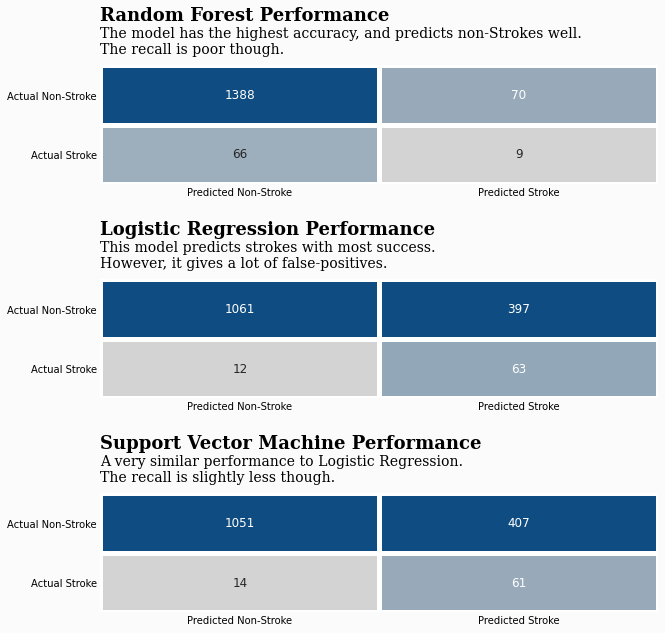

In [63]:
# Plotting our results

colors = ["lightgray","#0f4c81","#0f4c81","#0f4c81","#0f4c81","#0f4c81","#0f4c81","#0f4c81"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)


background_color = "#fbfbfb"

fig = plt.figure(figsize=(10,14)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.8)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])
ax2 = fig.add_subplot(gs[2, :])
ax0.set_facecolor(background_color) # axes background color

# Overall
sns.heatmap(rf_cm, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax0,
            yticklabels=['Actual Non-Stroke','Actual Stroke'],xticklabels=['Predicted Non-Stroke','Predicted Stroke'],annot_kws={"fontsize":12})

sns.heatmap(logreg_cm, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax1,
            yticklabels=['Actual Non-Stroke','Actual Stroke'],xticklabels=['Predicted Non-Stroke','Predicted Stroke'],annot_kws={"fontsize":12})

sns.heatmap(svm_cm, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax2,
            yticklabels=['Actual Non-Stroke','Actual Stroke'],xticklabels=['Predicted Non-Stroke','Predicted Stroke'],annot_kws={"fontsize":12})



ax0.tick_params(axis=u'both', which=u'both',length=0)
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 
ax1.tick_params(axis=u'both', which=u'both',length=0)
ax1.set_facecolor(background_color) 
ax2.tick_params(axis=u'both', which=u'both',length=0)
ax2.set_facecolor(background_color)

ax0.text(0,-0.75,'Random Forest Performance',fontsize=18,fontweight='bold',fontfamily='serif')
ax0.text(0,-0.2,'The model has the highest accuracy, and predicts non-Strokes well.\nThe recall is poor though.',fontsize=14,fontfamily='serif')

ax1.text(0,-0.75,'Logistic Regression Performance',fontsize=18,fontweight='bold',fontfamily='serif')
ax1.text(0,-0.2,'This model predicts strokes with most success.\nHowever, it gives a lot of false-positives.',fontsize=14,fontfamily='serif')

ax2.text(0,-0.75,'Support Vector Machine Performance',fontsize=18,fontweight='bold',fontfamily='serif')
ax2.text(0,-0.2,'A very similar performance to Logistic Regression.\nThe recall is slightly less though.',fontsize=14,fontfamily='serif')


plt.show()

# Conclusion

In summary, Logistic Regression has the best performance in identifying stroke patients. However, it also wrongly predicts many normal people to have stroke. 

Thus, in order to apply the results we would need to closely review our goal of the study: is the trade-off between more accurately indentified stroke patients and normal people fair enough? In real life, I believe that it would be better that we propose medication / preventive actions for more people in order to prevent stroke, which the results of Logistic Regression is suggesting.